In [155]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import random
import cv2
from sklearn import metrics
from tqdm.notebook import trange, tqdm
from sklearn import preprocessing
import sys
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import glob

import warnings
warnings.filterwarnings('ignore')

<b>Useful source:</b> https://towardsdatascience.com/wtf-is-image-classification-8e78a8235acb (general basic knowledge how to start dealing with computer vision), https://towardsdatascience.com/image-pre-processing-c1aec0be3edf (how to pre-process data), https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/ (how cnn works), https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/ (quick introduction to nn in general), https://towardsdatascience.com/image-processing-techniques-for-computer-vision-11f92f511e21 (images preprocessing and data augmentation)

### Operations used:

#### 1) Standarization

Resizing every image to exactly same shape

#### 2) Denoise 
Smoothing images to remove noise we do not want them to appear on our photos. Noise is somrthing unwanted wich do not bring any information, moreover it could disrupt our model in recognizing our target. Our action helps enhance image structures.

#### 3) Grayscale (finally not used)

Due to only one color channel in grayscale photos processing is at least 3 times faster. To gender recognition photos color in my opinion is not useful. When we will be predicting ethnicity in the next project's stage, color of photos could be useful. I will find out it during work on the second stage of project, because it's my first step to understand computer vision, so my knowledge about it is a bit basic now.

In computer vision is something called thumb rule to recognize color importance in a project. It refers to look at the picture with human eye and try to recognize object we are looking for in a grayscaled photo. If we can, color it's not important. I think that we are able to approximate human age without colors attendance at the picture, so in my opinion this rule is fullfiled in this case.

<b>Useful source:</b> https://manningbooks.medium.com/the-computer-vision-pipeline-part-3-image-preprocessing-c662094835ec

#### 4) Normalization
Firstly normalization of photos' pixels helps us avoid situation where big pixels dominate smaller ones because of huge range (here 0 to 255). Secondly many algorithms behave well on normalized data rather than on not normalized.

<b>Useful source:</b> https://medium.com/@kharikri/image-processing-tips-for-computer-vision-and-deep-learning-tasks-e5247ec94f3

### Loading images and data manipulations

In [240]:
# resizing variables
height, width = 128, 128
gray_scale = False
if gray_scale == True:
    channels = 1
else:
    channels = 3

In [158]:
def load_photo_and_preprocess(
    path_to_images, 
    class_1, 
    class_2,
    height,
    width,
    gray_scale = True,
):
    X = []
    y = []
    os.chdir(path_to_images)
    for img_name in tqdm(os.listdir(path_to_images)):
        img = cv2.imread(img_name)   
        # Standarization
        img = cv2.resize(img, (height, width), interpolation = cv2.INTER_AREA)
        # Denoise
        img = cv2.GaussianBlur(img, (5, 5), 0)
        # Grayscale
        if gray_scale == True:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            pass
        # Normalization
        img = img/255
        X.append(img)
        # Getting labels
        if img_name.split('.')[0] == class_1:
            y.append(0) 
        elif img_name.split('.')[0] == class_2:
            y.append(1) 

    # transforming label to appropriate format
    y = k.utils.to_categorical(y, num_classes=2)
    
    # list to array transform
    X = np.array(X)
    
    return X, y

In [159]:
X, y = load_photo_and_preprocess(
    '/Users/alexdrozdz/JupyterNotebook/Cats_dogs/Data',
    'cat',
    'dog',
    height,
    width,
    gray_scale = gray_scale,
)

In [160]:
print("Image shape: ", X[0].shape)

Image shape:  (128, 128, 3)


In [192]:
def plot_image(
    index, 
    X, 
    y, 
    class_1, 
    class_2,
    gray_scale = True,
):
    if gray_scale == True:
        plt.imshow(X[index], cmap='gray')
    else:
        img = X[index]
        # opencv only supports image display and operation of float32, 
        # then float64 is a numpy data type, which is not supported in opencv.
        img = img.astype('float32')
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        plt.imshow(img)
    plt.show()
    if y[index][0] == 1:
        label = class_1
    elif y[index][0] == 0:
        label = class_2
    print(f"Label: {label}")

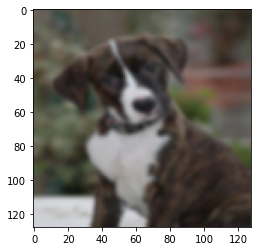

Label: dog


In [233]:
plot_image(np.random.randint(len(X)), X, y, 'cat', 'dog', gray_scale = gray_scale)

#### Train test split

In [261]:
print(f"Dataset length: {len(X)}")

Dataset length: 25000


In [262]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state = 1234
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, shuffle=True, random_state = 1234
)

In [263]:
data_inf_dict = {
    'X_train size': len(X_train),
    'X_test size': len(X_test),
    'X_val size': len(X_val),
    'y_train size': len(y_train),
    'y_test size': len(y_test),
    'y_val size': len(y_val),
}

data_inf_dict

{'X_train size': 20000,
 'X_test size': 2500,
 'X_val size': 2500,
 'y_train size': 20000,
 'y_test size': 2500,
 'y_val size': 2500}

In [264]:
def count_ratio(y, name):
    class_0 = []
    class_1 = []
    for element in y:
        if element[0] == 0:
            class_0.append(1)
        if element[0] == 1:
            class_1.append(1)        
            
    ratio = str(
        round(len(class_0)/(len(class_1)+len(class_0))*100,2)
    ) + '/' + str(
        100 - round(len(class_0)/(len(class_1)+len(class_0))*100,2)
    )
    
    print(f"{name} balance ratio: {ratio}")

In [265]:
count_ratio(y_train, 'y_train')
count_ratio(y_test, 'y_test')
count_ratio(y_val, 'y_val')

y_train balance ratio: 49.9/50.1
y_test balance ratio: 49.88/50.12
y_val balance ratio: 50.96/49.04


Classes in datasets are almost perfectly balanced after shuffle

### Convolutional Neural Network

#### Convolution layer
Used to extract (filter) certain features from group of pixels

#### Filters
A set of weights - filter - to extract local features in convolutional layer

The goal of using filters is to modify or enhance image properties and/or to extract valuable information from the pictures such as edges, corners, and blobs.

Goals:
- Extract out important information.
- Remove noise or unwanted elements.
- Enhance the image.
- Give a certain look

#### Non-linearity layer
Often ReLU. Allows to deal with non-linearity data. ReLU change every negative value to 0.

#### Pooling layer
Using to reduce dimensionality of input layer. 

#### 3 steps of feature learning:

1. Learn features in input image through convolution
2. Introduce non-linearity through activation function (real-world data is non-linear!)
3. Reduce dimensionality and preserve spatial invariance with pooling

#### Classification:
After these 3 steps the next part of CNN is classification: 
- CONV and POOL layers output high-level features of input
- Fully connected layer uses these features for classyfing input image
- Express output as probability of image belonging to a particular class

output features -> Fully Conected Layer (each neuron linked with each neuron, another name: Dense Layer) which output probability of image belongs to particulr class (softmax/sigmoid function)

<b>Useful source:</b> https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html, https://medium.com/towards-artificial-intelligence/image-filtering-dfe29581f859, https://www.youtube.com/watch?v=iaSUYvmCekI

In [267]:
if gray_scale == True:
    X_train = np.expand_dims(X_train, -1)
    X_val = np.expand_dims(X_val, -1)
    X_test = np.expand_dims(X_test, -1)
else:
    pass

##### Batch:
We can’t pass the entire dataset into the neural net at once. So, it's a need to divide dataset into parts, and batch size is a size of these parts.

##### Epochs:
One epoch means one pass of dataset forward and backward (computing and then weights adjusting).

##### Iterations:
Iterations is the number of batches needed to complete one epoch. 1000 training examples could be divided into baches of 100, then we need 10 iterations to end one epoch.

<b>Useful source:</b> https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

In [268]:
input_shape = (height, width, channels)
batch_size = 32
epochs = 10
classes = 2

In [269]:
# cnn model initialization
model = Sequential([
    k.layers.Conv2D(
        filters=32, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu', 
        input_shape=input_shape,
    ),
    k.layers.MaxPooling2D(
        pool_size=(2,2)
    ),
    k.layers.Dropout(0.5),
    k.layers.BatchNormalization(),
    k.layers.Conv2D(
        filters=64, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ),
    k.layers.MaxPooling2D(
        pool_size=(2,2)
    ), 
    k.layers.Dropout(0.5),
    k.layers.BatchNormalization(),
    k.layers.Conv2D(
        filters=128, 
        kernel_size=(3,3), 
        padding='same', 
        activation='relu'
    ),
    k.layers.MaxPooling2D(
        pool_size=(2,2)
    ), 
    k.layers.Dropout(0.5),
    k.layers.BatchNormalization(),
    # flatten converts our 3D feature maps to 1D feature vectors
    k.layers.Flatten(),
    k.layers.Dense(
        128, 
        activation='relu'
    ),
    k.layers.Dense(
        classes,
        activation='sigmoid'
    )
])

In [270]:
# build model
opt = k.optimizers.Adam(lr = 5e-3)
model.compile( 
    loss = "binary_crossentropy", 
    optimizer = opt, 
    metrics=['accuracy']
)

In [271]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 32, 32, 64)      

In [272]:
# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [273]:
# train the model
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/10
625/625 [==============================] - 300s 480ms/step - loss: 0.7178 - accuracy: 0.5416 - val_loss: 0.6966 - val_accuracy: 0.5564
Epoch 2/10
625/625 [==============================] - 277s 444ms/step - loss: 0.6724 - accuracy: 0.5968 - val_loss: 0.6692 - val_accuracy: 0.6072
Epoch 3/10
625/625 [==============================] - 277s 444ms/step - loss: 0.6319 - accuracy: 0.6582 - val_loss: 0.7052 - val_accuracy: 0.5512
Epoch 4/10
625/625 [==============================] - 273s 436ms/step - loss: 0.6024 - accuracy: 0.6913 - val_loss: 0.6049 - val_accuracy: 0.6764
Epoch 5/10
625/625 [==============================] - 270s 432ms/step - loss: 0.5651 - accuracy: 0.7202 - val_loss: 0.6191 - val_accuracy: 0.6596
Epoch 6/10
625/625 [==============================] - 270s 433ms/step - loss: 0.5469 - accuracy: 0.7323 - val_loss: 0.6829 - val_accuracy: 0.6352
Epoch 7/10
625/625 [==============================] - 273s 437ms/step - loss: 0.5210 - accuracy: 0.7498 - val_loss: 0.5528 -

In [274]:
score = model.evaluate(X_test, y_test, verbose=0)

In [275]:
print(f"Model accuracy: {round(score[1]*100,2)}%")

Model accuracy: 75.88%


#### Predicition on my private dog photo

In [280]:
X_predict, y_predict = load_photo_and_preprocess(
    '/Users/alexdrozdz/JupyterNotebook/Cats_dogs/my_dog',
    'cat',
    'dog',
    height,
    width,
    gray_scale=False
)

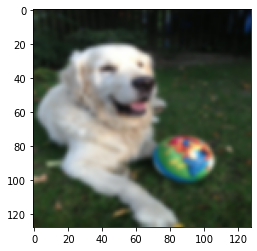

Label: dog


In [281]:
plot_image(0, X_predict, y_predict, 'cat', 'dog', gray_scale=False)

In [282]:
if gray_scale == True:
    X_predict = np.expand_dims(X_predict, -1)
else:
    pass

In [284]:
prediction = model.predict(X_predict)

In [285]:
if prediction[0][1] > 0.5:
    print(
        f"Hey, that's right! Of course it's a dog! \nDog probability: {round(prediction[0][1]*100,2)}%, Cat probability: {round(prediction[0][0]*100,2)}%. \nBtw his name is Billy :)"
    )
elif prediction[0][1] < 0.5:
    print(
        f"Egh prediction is bad! For a model it's a cat \nDog probability: {round(prediction[0][1]*100,2)}%, Cat probability: {round(prediction[0][0]*100,2)}%"
    )

Hey, that's right! Of course it's a dog! 
Dog probability: 87.22%, Cat probability: 12.78%. 
Btw his name is Billy :)
